In [1]:
import glob
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
df.shape

(2782629, 2)

In [4]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadź STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64)  # Możesz dostosować parametry, takie jak nperseg
        Zxx = np.abs(Zxx)
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx)
        Y.append(df_temp_2.iloc[i + win_len, -1])
        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1))
Y = np.array(Y) 

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

C:\Users\justy\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 64 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


In [5]:
X.shape

(9246, 28, 28, 1)

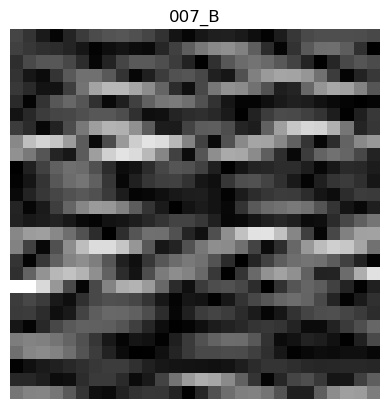

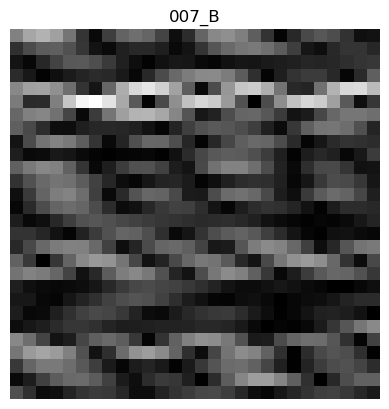

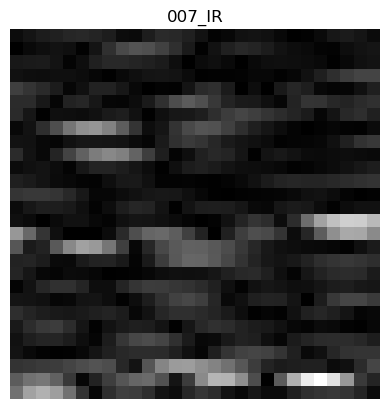

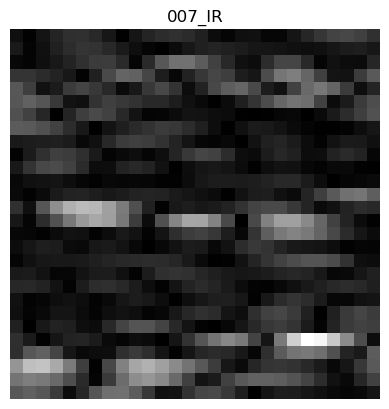

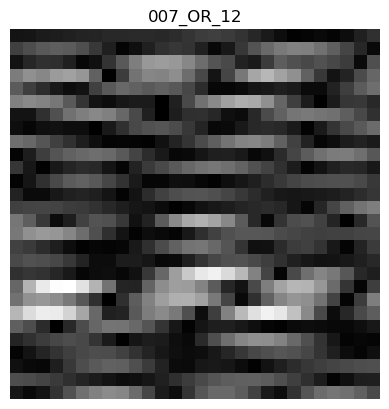

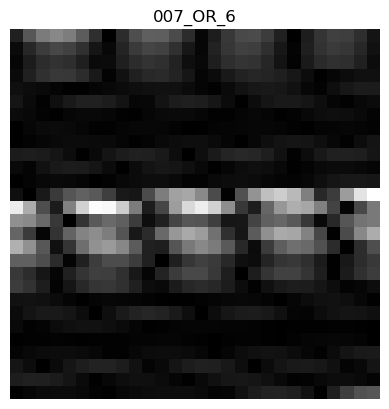

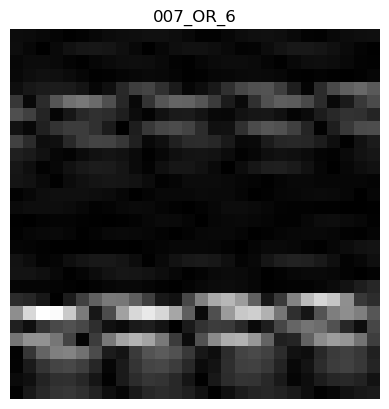

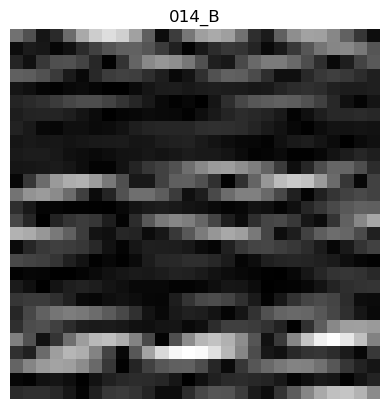

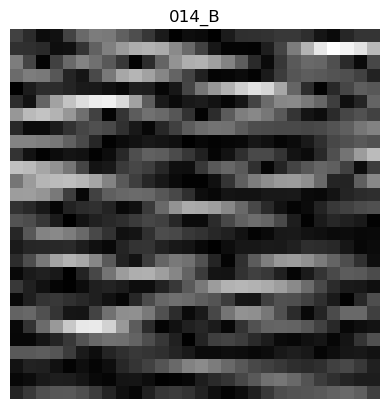

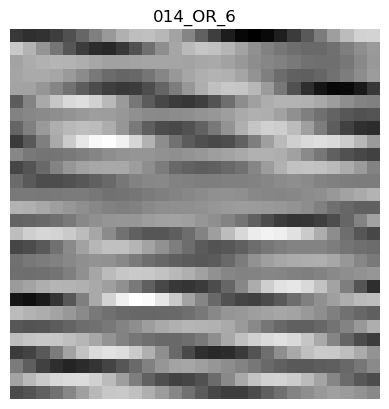

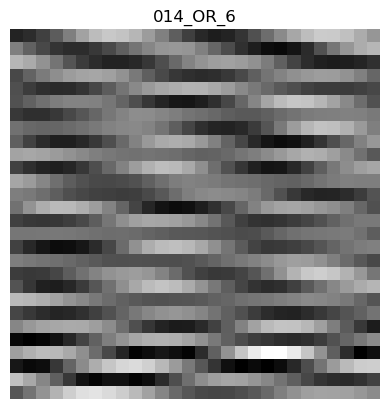

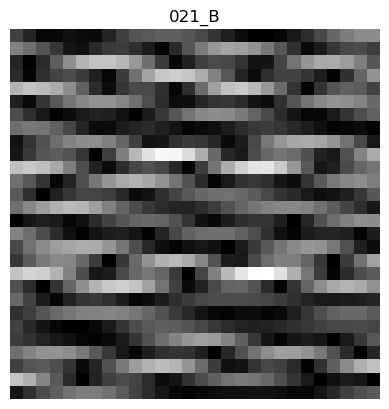

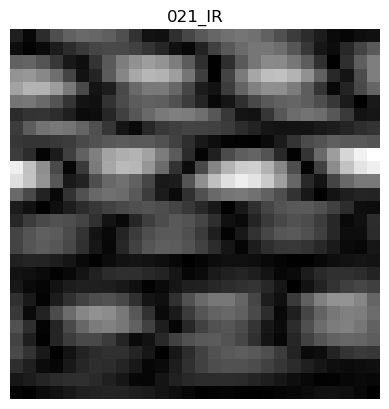

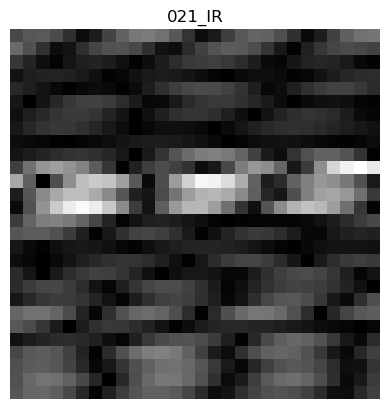

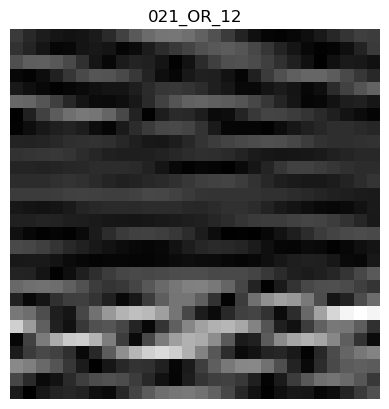

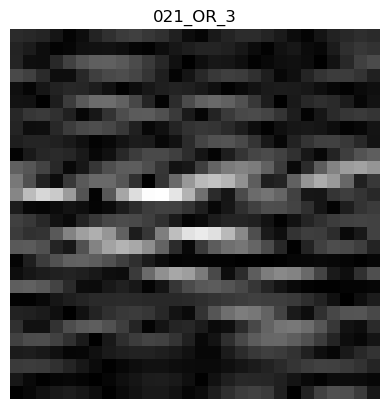

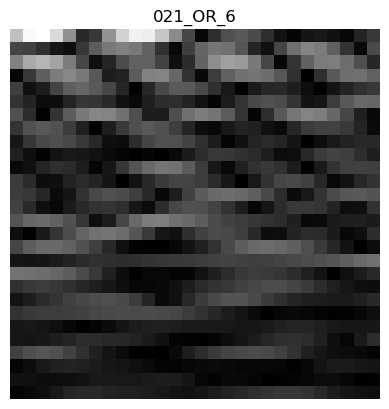

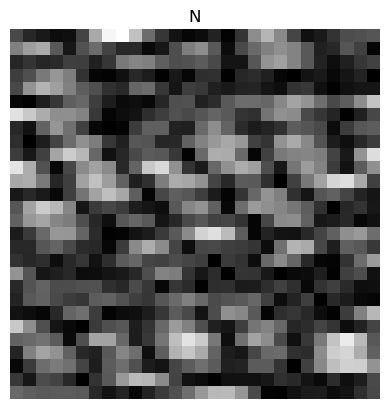

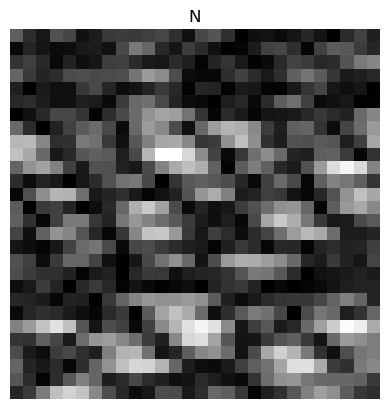

In [6]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [8]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [10]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

Epoch 1/80
17/17 [==============================] - 4s 202ms/step - loss: 2.4395 - accuracy: 0.0983 - val_loss: 2.2590 - val_accuracy: 0.1727
Epoch 2/80
17/17 [==============================] - 3s 183ms/step - loss: 2.0627 - accuracy: 0.2568 - val_loss: 1.7649 - val_accuracy: 0.4391
Epoch 3/80
17/17 [==============================] - 3s 187ms/step - loss: 1.5189 - accuracy: 0.5212 - val_loss: 1.2974 - val_accuracy: 0.5166
Epoch 4/80
17/17 [==============================] - 3s 195ms/step - loss: 1.0534 - accuracy: 0.6506 - val_loss: 1.0018 - val_accuracy: 0.6683
Epoch 5/80
17/17 [==============================] - 3s 196ms/step - loss: 0.7928 - accuracy: 0.7273 - val_loss: 0.6928 - val_accuracy: 0.7729
Epoch 6/80
17/17 [==============================] - 3s 206ms/step - loss: 0.6310 - accuracy: 0.7880 - val_loss: 0.5790 - val_accuracy: 0.7909
Epoch 7/80
17/17 [==============================] - 3s 191ms/step - loss: 0.5500 - accuracy: 0.8143 - val_loss: 0.5886 - val_accuracy: 0.7830
Epoch 

87/87 [==============================] - 1s 8ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

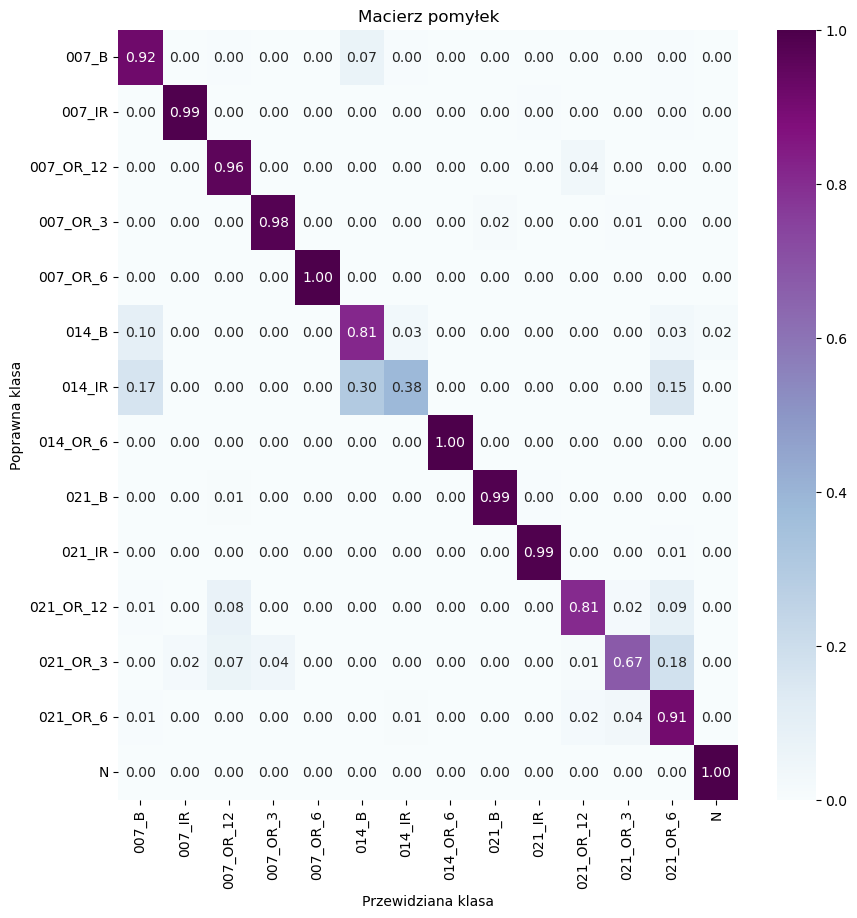

In [11]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

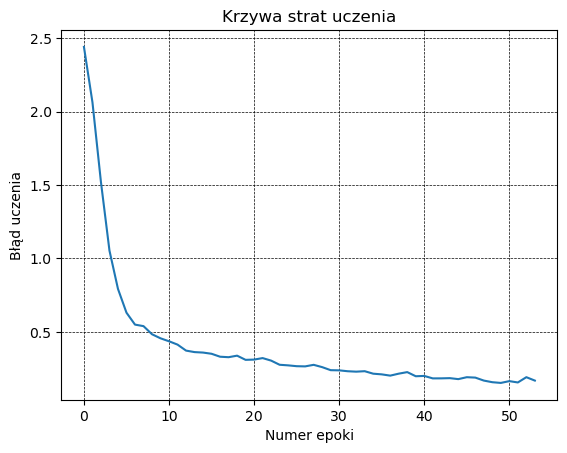

In [12]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

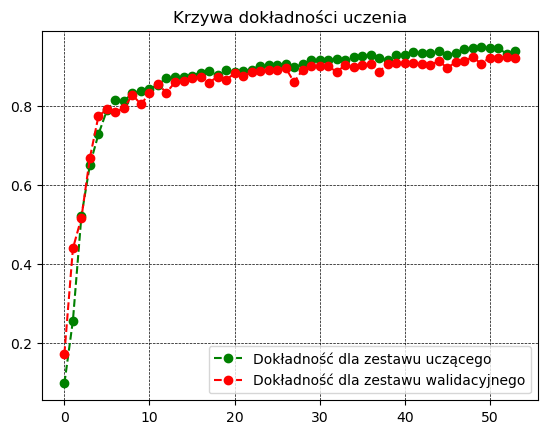

In [13]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

203/203 [==============================] - 1s 7ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.001s...
[t-SNE] Computed neighbors for 6472 samples in 0.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 1.265515
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.784912
[t-SNE] KL divergence after 300 iterations: 2.110764


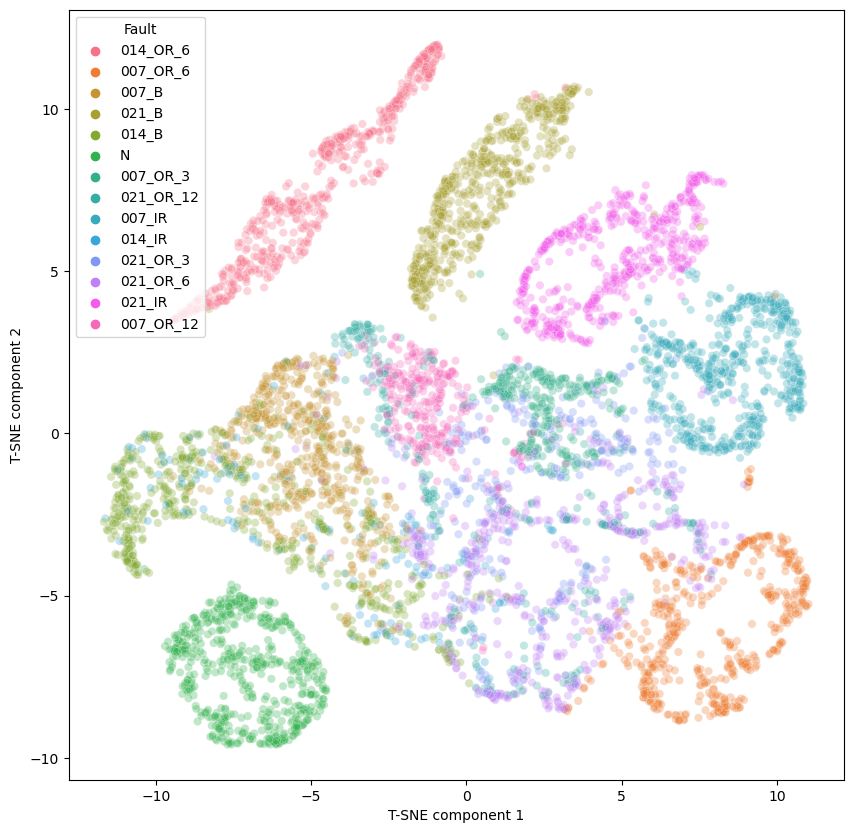

In [14]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
df = pd.read_csv('1hp_all_faults.csv')

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadź STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64)  # Możesz dostosować parametry, takie jak nperseg
        Zxx = np.abs(Zxx)
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx)
        Y.append(df_temp_2.iloc[i + win_len, -1])
        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1))
Y = np.array(Y)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [ ]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

In [ ]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

In [ ]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [ ]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

In [ ]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
df = pd.read_csv('2hp_all_faults.csv')

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadź STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64)  # Możesz dostosować parametry, takie jak nperseg
        Zxx = np.abs(Zxx)
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx)
        Y.append(df_temp_2.iloc[i + win_len, -1])
        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1))
Y = np.array(Y)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [ ]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

In [ ]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

In [ ]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [ ]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

In [ ]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
df = pd.read_csv('3hp_all_faults.csv')

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len = 784
stride = 300

X = []
Y = []

for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k]

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadź STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64)  # Możesz dostosować parametry, takie jak nperseg
        Zxx = np.abs(Zxx)
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx)
        Y.append(df_temp_2.iloc[i + win_len, -1])
        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1))
Y = np.array(Y)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [ ]:
from matplotlib.pyplot import imread


for idx in range(0,9244,500):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

In [ ]:
# Definiujesz wczesne zatrzymywanie
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trenujesz model z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodajesz wczesne zatrzymywanie do listy callbacks
)

In [ ]:
def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [ ]:
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

In [ ]:
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)
y_viz = dummy_cnn.predict(X_train)
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [ ]:
STFT_train_accouracy=[94.07, 89.60, 89.34, 91.19]
STFT_test_accuracy=[92.47, 84.70, 85.24, 86.91]

models = ('A', 'B', 'C', 'D') 
STFT_data = {
'STFT_train_accouracy' : (94.07, 89.60, 89.34, 91.19), 
'STFT_test_accuracy' : (92.47, 84.70, 85.24, 86.91),
}

x = np.arange(len(models))
width = 0.4
multiplier = 0
fig, ax = plt.subplots(layout = 'constrained')
for attribute, measurement in STFT_data.items():
    offset = width * multiplier
    rects= ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
ax.set_ylabel('Dokładność [%]')
ax.set_xlabel('Zbiór danych')
ax.set_title('Zbiór treningowy vs zbiór testowy')
ax.set_xticks(x + width, models)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 115)
plt.show()